# Question Two: Promotions and Profit Strategy

Foodmart runs hundreds of promotions a year in an effort to boost profits. Understanding which promotions actually do so, and focusing on them, seems like a core component of any profit growth strategy.

The first step is to measure the _total gross profit_ associated with each promotion - the sum of gross profits for each transaction that occured under the given promotion. (A transaction's gross profit is its revenue minus its costs.)

Once we know every promotion's total gross profit, we can:
1. Understand which promotion types appear most profitable, and are worth pursuing in 1998
2. Calculate each's media channel's return-on-investment - the average profit for promotions advertised through those channels, minus the cost of advertising.
3. Understand which months of year appear to be th most profitable times to run promotions.

In [1]:
from os import environ
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load cleaned datasets into DataFrame from Make through env variables.
dataset_paths = ['../' + dataset for dataset in environ['datasets'].split()]
product, product_class, promotion, transactions = [pd.read_pickle(path) for path in dataset_paths]


To compute _total gross profit_, we must first join transaction to promotions, products, and product classes.

In [3]:
trans_prod = pd.merge(transactions, product, on='product_id', how='inner')
trans_prod_class = pd.merge(trans_prod, product_class, on='product_class_id', how='inner')
trans_prod_promo = pd.merge(trans_prod_class, promotion, on='promotion_id', how='inner')

Then, we find the gross profit of each transaction by subtracting its sales revenue from its sales cost.

In [4]:
trans_prod_promo['gross_profit'] = trans_prod_promo['store_sales'] - trans_prod_promo['store_cost']

Now, let's sum up those transaction profits for each promotion..

In [5]:
profits_by_promotion = trans_prod_promo.groupby('promotion_id')['gross_profit'] \
                                       .sum() \
                                       .reset_index() \
                                       .rename(columns={'gross_profit': 'total_gross_profit'})

..and take a look at the resulting distribution.

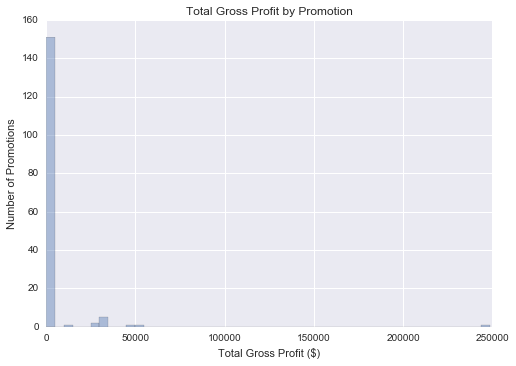

In [6]:
sns.distplot(profits_by_promotion['total_gross_profit'], kde=False)
plt.title('Total Gross Profit by Promotion')
plt.xlabel('Total Gross Profit ($)')
plt.ylabel('Number of Promotions')

Whoops! We can't see much of anything because of an outlier.

In [7]:
profits_by_promotion.head(2)

,promotion_id,total_gross_profit
0,0,248798.1793
1,2,2842.6126


As we discovered in our data quality analysis, the promotion with id = 0 represents "no promotion". So that outlier value - 248,798 - is the total gross profit Foodmart made outside of promotions in 1997. Let's exclude this dummy promotion from the rest of the analysis.

In [8]:
# The promotion with id == 0 represents "no promotion". Remove it from the analysis.
profits_by_promotion = profits_by_promotion[~(profits_by_promotion['promotion_id'] == 0)]

Now, let's try to take a look at the distribution of total gross profits again:

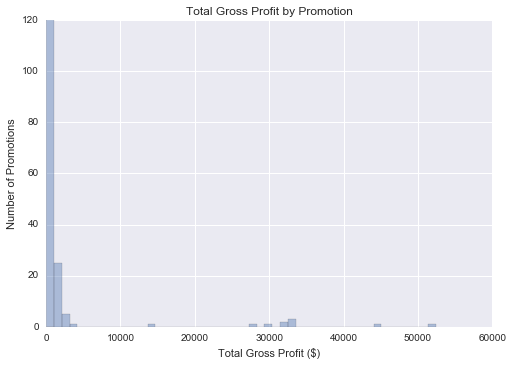

In [9]:
sns.distplot(profits_by_promotion['total_gross_profit'], kde=False)
plt.title('Total Gross Profit by Promotion')
plt.xlabel('Total Gross Profit ($)')
plt.ylabel('Number of Promotions')

In [10]:
np.percentile(profits_by_promotion, 95)

1868.8499999999999

95% of promotions had less than $1868 in total profits. These numbers are abnormally low, due to the "random sample" problem uncovered in the data quality analysis - we only have a very small sample of all the transactions that _actually_ occured under the promotion, so the total profits are artificially low.

This could affect our ability to do an ROI analysis, because the promotion _cost_ figures haven't been adjusted accordingly - we can see the entire cost of running each promotion, but only a small fraction of the profit associated with it.

Still, if we assume that the transactions in `transactions.csv` were sampled at random, we could still learn something useful about the relative profitability of different kinds of promotions - whether certain media types are associated with higher returns, and so on.

So, onward!

Okay, so we're observed a bit of variation in total profit between promotions. Perhaps promotion with larger profits simply run longer. 

So we should normalize our profit figures by the number of days the campaign ran. To do that, we must join them to the `promotion` DataFrame, which holds the start and end date of each promotion.

In [11]:
promotion_profit = profits_by_promotion.join(promotion, on='promotion_id', how='inner', rsuffix='_r', lsuffix='_l')

To compute the number of days each promotion ran, we take the difference between a promotion's end date and start date.

In [12]:
promotion_profit['num_days'] = (promotion_profit['end_date'] - promotion_profit['start_date']).dt.days

Now, we can take a look at the distribution:

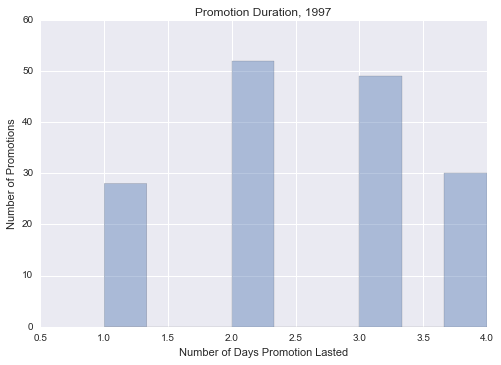

In [13]:
sns.distplot(promotion_profit['num_days'], kde=False)
plt.title('Promotion Duration, 1997')
plt.xlabel('Number of Days Promotion Lasted')
plt.ylabel('Number of Promotions')

Yep, it looks like campaigns range from in duration from 1 to 4 days. Let's use this information to normalize our promotion profit figures:

In [14]:
promotion_profit['total_profit_per_day'] = promotion_profit['total_gross_profit'] / promotion_profit['num_days']

Now, we're ready to explore potential drivers of profitable promotions.

## Profits by Type of Promotion - promotion_name

In [15]:
promotion_profit.shape[0]

159

In [16]:
promotion_profit['promotion_name'].nunique()

46

There are 159 promotions in our 1997 transactions dataset, grouped into 46 _promotion names_ - "Sales Galore", "Weekend Markdown", and so on.

(Due to these promotions being derived from a small sample of transations, the real number of promotions that ran in 1997 is much larger - see the data quality notebook.)

Let's look at the average daily profits of each promotion name:

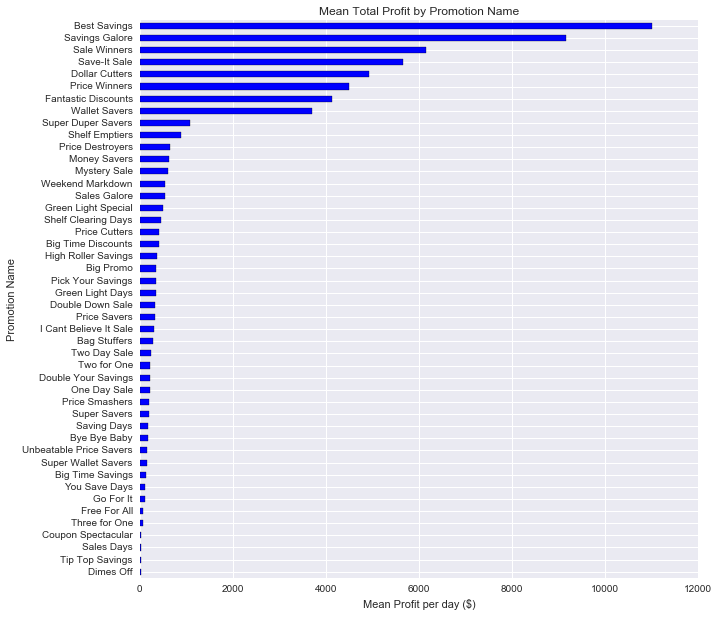

In [154]:
# Aggregate daily promotion profit by promotion name, take the mean.
plt.figure(figsize=(10,10))
mean_profit_by_promotion_name = promotion_profit.groupby('promotion_name')['total_profit_per_day'].mean().sort_values()

# Plot mean daily profit for each promotion name.
mean_profit_by_promotion_name.plot(kind='barh')
plt.title('Mean Total Profit by Promotion Name')
plt.xlabel('Mean Profit per day ($)')
plt.ylabel('Promotion Name')

# Save plot to disk for use in executive summary.
plt.savefig('mean_total_profit_by_promo_name.png')

The top 8 most profitable promotion types range from approximately \$4,000 to \$11,000 per day. 

They appear to be in a league of their own, well ahead of every other promotion name, which made under \$1,000 per day in our transaction sample.

What percentage of 1997 promotions belonged to one of these "top" promotion types?

In [81]:
# Get Series of top promotion names - Best Savings, Savings Galore, etc.
top_promotion_names = mean_profit_by_promotion_name[mean_profit_by_promotion_name > 2000]

# Find 1997 promotions that belong to one of these promotion names.
top_promotions = pd.merge(top_promotion_names.reset_index(), promotion_profit, on='promotion_name')

# Find percentage of 1997 promotions that belong to a top promotion name.
top_promotions.shape[0] / promotion_profit.shape[0]  # This is the set of 1998 promotions, with total profit info.

0.20754716981132076

And what percentage of all promotion profits do the profits of these promotions represent?

In [98]:
# Find total profits of 1997 promotions belonging to a "top" promotion name.
top_promotion_profit = top_promotions.total_profit_per_day_x.sum()
# Find total profits of all 1997 promotions.
total_promotion_profit = promotion_profit.total_profit_per_day.sum()
# Find the share of 1997 promotion profits that belong to a promotion in a "top" name.
top_promotion_profit / total_promotion_profit

0.81363568660894459

In other words, 20% of promotions brought in 80% of the profits. These promotions all belonged to one of 8 "highly profitable" promotion types, whose promotions made an average of \$3,700+ in profit per day. All other promotion types had much lower 'profit velocities', around \$1,000 in daily profit.

What makes a certain type of promotion more profitable per day than another? The biggest driver by far is simply the number of daily transactions associated with that promotion. To make sure we didn't screw anything up, let's confirm this:

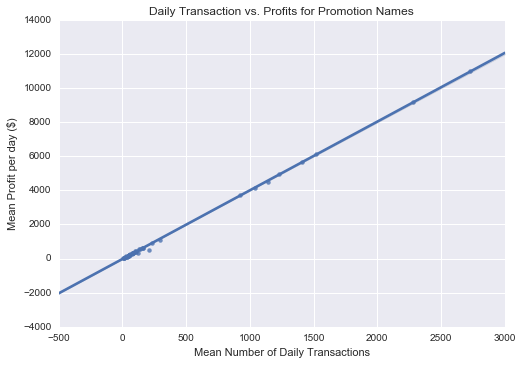

In [19]:
# Calculate the number of transactions per promotion id.
trans_with_promo = trans_prod_promo[trans_prod_promo['promotion_id'] != 0]  # Exclude non-promotion transactions.
trans_per_promo = trans_with_promo.groupby('promotion_id').size().reset_index().rename(columns={0:'num_transactions'})

# Normalize the total nubmer of transactions per promotion by the number of days the promotion ran.
promotion_trans = pd.merge(trans_per_promo, promotion_profit, left_on='promotion_id', right_on='promotion_id_l', how='inner')
promotion_trans['num_transactions_per_day'] = promotion_trans['num_transactions'] / promotion_trans['num_days']

# Aggregate promotion-level daily profits and transactions to promotion-name-level mean daily profits and transactions. 
daily_profit_by_promotion_name = promotion_profit.groupby('promotion_name')['total_profit_per_day'].mean()
num_transactions_by_promotion_name = promotion_trans.groupby('promotion_name')['num_transactions_per_day'].mean()
# Make a scatterplot and fit a regression line to show relationship.
sns.regplot(x=num_transactions_by_promotion_name, y=daily_profit_by_promotion_name)

plt.title('Daily Transaction vs. Profits for Promotion Names')
plt.xlabel('Mean Number of Daily Transactions')
plt.ylabel('Mean Profit per day ($)')

**Recommendation**: management should pursue more promotions of the following types:
        Best Savings, Savings Galore, Save-It Sale, Dollar Cutters, Price Winners, Fantastic Discounts, and Wallet Savers.

## Profits by Media Channel - media_type

We now have an idea of which promotion types were the _most_ profitable in 1997. (Knowing whether they were profitable enough is hard to say without having the full transactions dataset, or at least knowing what percentage of all transactions are in our sample.)

But what about the media channel through which a promotion was advertised? Does it matter if you promote a sale through TV vs. Newspaper vs. in-store ads?

To answer that, let's look at the mean daily profit of promotions by media type.

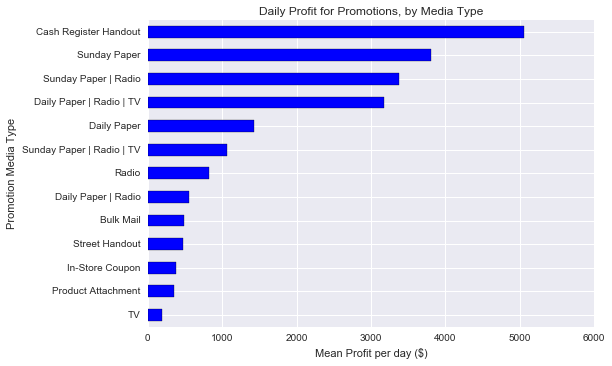

In [159]:
promotion_profit.groupby('media_type')['total_profit_per_day'].mean().sort_values().plot(kind='barh')
plt.title('Daily Profit for Promotions, by Media Type')
plt.xlabel('Mean Profit per day ($)')
plt.ylabel('Promotion Media Type')
plt.savefig('mean_total_profit_by_media_type.png', bbox_inches='tight')

Like we saw for promotion types, a small pack of media channels stick out - Crash Register Handout, Sunday Paper, Sunday Paper and Radio, Daily Paper and Radio and TV.

Before we tell management to pour money into promotion these channels, let's see how cost effective they are.

## ROI of media channels

To gauge the return on investment of different media channels, we need to compare profits to costs.

Recall that we normalized total promotion profits by the number of days they lasted, in order to be able to directly compare the profitability of promotions with different durations. We must now do the same to costs:

In [22]:
promotion_profit['cost_per_day'] = promotion_profit['cost'] / promotion_profit['num_days']

Having constructed that new variable, we can now compute the average promotion profits / costs for every media channel, and plot the results.

In [23]:
profit_cost_by_media = promotion_profit.groupby('media_type').agg({'total_profit_per_day': np.mean, 'cost_per_day': np.mean})

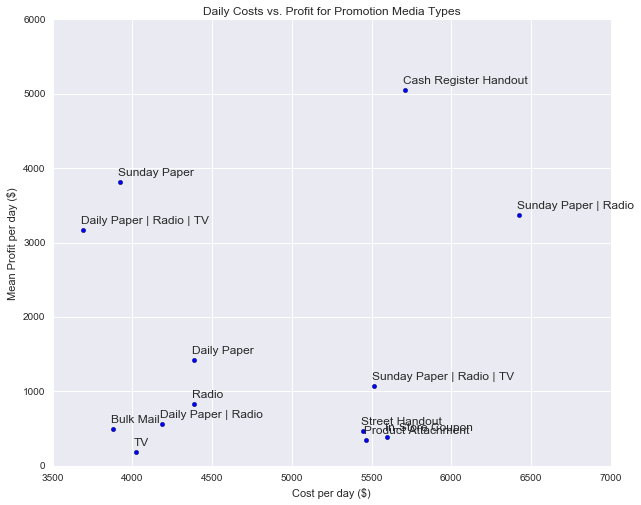

In [158]:
# Make scatterplot for daily promotion profits vs. costs, by media type
plt.figure(figsize=(10, 8))
plt.ylim(0, 6000)
plt.scatter(profit_cost_by_media['cost_per_day'], profit_cost_by_media['total_profit_per_day'])

# Annotate each coordinate pair with a media channel label.
for ix, (media_type, cost_per_day, total_profit_per_day) in profit_cost_by_media.reset_index().iterrows():
    plt.annotate(media_type, xy = (total_profit_per_day, cost_per_day), 
                 xytext = (-2, 7), textcoords='offset points')
    
plt.title('Daily Costs vs. Profit for Promotion Media Types')
plt.ylabel('Mean Profit per day ($)')
plt.xlabel('Cost per day ($)')
plt.savefig('costs_vs_profit_media_types.png')

(First, an important caveat about this data: as noted above, and in the data quality analysis, we are severly understimating the true mean profit per day of promotions, because our transaction data likely comes from a random sample. 

This means that we can't do a direct comparison between media channel profits - which are much smaller than they were in reality - and channel costs. 

We can't directly measure which promotion media channels "broke even", meaning their mean daily profits exceeded their mean daily costs. But we can gauge, at least directionally, which channels were cost effective _compared to all the others_.)

**Adding the cost dimension reveals something interesting: Sunday Paper and Daily Paper + Radio + TV channels are cost effective, while Sunday Paper + Radio is not.**

Even though Sunday Paper + Radio brought in ~$3,500 a day, in the same ballpark as those other two channels, it is 65% more expensive. 

Management should put money into Sunday Paper and Daily Paper + Radio + TV - they brought in 3-4 times more profit than the majority of channels - but not into Sunday Paper.

What about Cash Register Handout? Despite bringing in 25% more money per day than Sunday Paper, the second most profitable channel, it is also more expensive. 

Is the extra cost worth it? Let's find the percentage change in profit between the two channels, and compare it to the percent change in cost:

In [25]:
(profit_cost_by_media.loc['Cash Register Handout'] - profit_cost_by_media.loc['Sunday Paper']) / profit_cost_by_media.loc['Sunday Paper'] * 1

total_profit_per_day    0.325913
cost_per_day            0.454932
dtype: float64

Cash register handouts cost 45% more than Sunday Paper ads, and brought in 32% more profit. So it's slightly less cost-effective than Sunday Paper, but still worth investing in. 

**Recommendation**: management should focus on the following types of promotions: Sunday Paper, Daily Paper + Radio + TV, or Cash Register Handout.